# Question 3.2 Which agricultural variable is affecting corn **grain density**? What is the importance of P relatively to other variables?

In this notebook, we aim at assessing the linear effect of agricultural conditions, including the P dosage, on **grain density**.

## Load data

Load data exported from the preprocessing session.

In [1]:
load("output/preprocessed.RData")

## Load packages

We obviously need the **`tidyverse`** package for data manipulation and plotting. **`ggthemes`** provides themes for plots. The **`nlme`** package is used for the linear mixted model. The **`broom`** package is used to create tidied **`nlme`** outputs.

In [2]:
library("tidyverse")
library("broom")
library("ggthemes")
library("nlme")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse



## Preparation to modeling

We select the variables to be included in the model.

In [3]:
var_mm <- c(soil_vars, weather_vars, "doseP", "P.Source")
data_mm <- data_rs[c("ID", "Year", "graindensity_g.L", var_mm)]

Filter out missing data.

In [4]:
data_mm <- data_mm %>%
  drop_na() %>%
  droplevels()

Data left for modelling:

In [5]:
print(paste('Number of lines:', nrow(data_mm)))
print(paste('Number of trials:', nlevels(data_mm$ID)))

[1] "Number of lines: 724"
[1] "Number of trials: 279"


## Linear model

We begin by scaling all variables by removing the mean and dividing by the standard deviation. This assures that the effects (slopes) of the model can be compared.

In [6]:
scaled_num <- data_mm %>% 
  select(-ID, -Year, -is_manure, -graindensity_g.L, -P.Source) %>%
  scale() %>%
  as_tibble()
data_mm_sc <- bind_cols(data_mm %>% select(ID, Year, is_manure, graindensity_g.L, P.Source), scaled_num)

We launch split the procedure in two parts, **with and without manure**, which are datasets conducted under different methodologies. Then we run a frequential linear mixed model for each on them, then arrange the table for ploting.

In [7]:
mm_lin <- data_mm_sc %>%
  split(.$is_manure) %>%
  map(~ intervals(lme(as.formula(paste("graindensity_g.L ~ ", paste(var_mm[var_mm != "is_manure"], collapse=" + "),
                               "+ doseP:Soil_P.Al")),
            random = ~ 1|Year/ID,
            data = .))$fixed) %>%
  map_dfr(~tidy(.), .id = 'is_manure') %>%
  rename(Variable = .rownames) %>%
  filter(Variable != "(Intercept)") %>%
  mutate(is_manure = ifelse(is_manure, "With manure", "Without manure"),
         Category = c("Soil chemistry", "Soil chemistry",
                      "Soil gensis", "Soil gensis",
                      "Soil texture", "Soil texture", "Soil texture",
                      "Weather", "Weather", "Weather",
                      "Dose",
                      "Dose","Dose","Dose",
                      "Dose",
                      "Soil chemistry", "Soil chemistry",
                      "Soil gensis", "Soil gensis",
                      "Soil texture", "Soil texture", "Soil texture",
                      "Weather", "Weather", "Weather",
                      "Dose",
                      "Dose",
                      "Dose"))

Warning message:
“'tidy.matrix' is deprecated.
See help("Deprecated")”Warning message:
“'tidy.matrix' is deprecated.
See help("Deprecated")”

Variables are renamed to readable string.

In [8]:
for (i in 1:nrow(translate_col)) {
  mm_lin$Variable <- sub(pattern = translate_col$from_name_mm[i], 
                                 replacement = translate_col$to_name_mm_long_en[i],
                                 x = mm_lin$Variable)
}

We plot the slopes and their confidence interval.

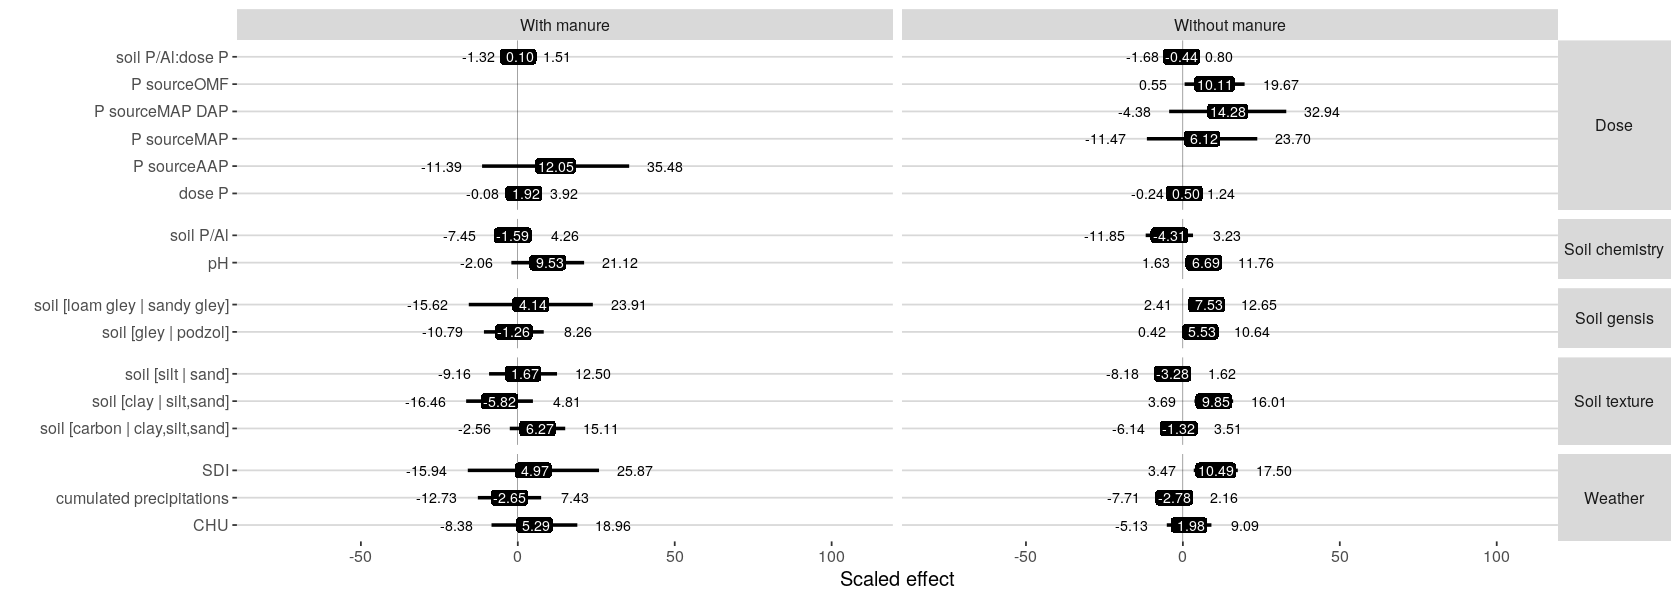

In [9]:
options(repr.plot.width = 14, repr.plot.height = 5)
mm_lin %>%
  ggplot() +
  geom_vline(xintercept = 0, lwd = 0.1) +
  geom_segment(aes(x = lower, xend = upper, y = Variable, yend = Variable), lwd = 1) +
  geom_label(aes(x = `est.`, y = Variable, label = format(round(est., 2), nsmall = 2)),
             size = 3, label.padding = unit(0.1, "lines"), colour = "white", fill = "black", label.size = 0) +
  geom_text(aes(x = lower, y = Variable, label = format(round(lower, 2), nsmall = 2)), size = 3, hjust = 1.5) +
  geom_text(aes(x = upper, y = Variable, label = format(round(upper, 2), nsmall = 2)), size = 3, hjust = -0.5) +
  facet_grid(Category ~ is_manure, scales = "free_y", space = "free_y") +
  labs(x = "Scaled effect", y = "") +
  expand_limits(x=c(-80, 110)) +
  theme_hc() +
  theme(strip.text.y = element_text(angle = 0))

In [10]:
ggsave("images/density_linmod.jpg", height = 5, width = 14, dpi = 300)

If we would want absolute effects, we use the dataset `data_mm` instead of `data_mm_sc`.

In [11]:
mm_lin_abs <- data_mm %>%
  split(.$is_manure) %>%
  map(~ intervals(lme(as.formula(paste("graindensity_g.L ~ ", paste(var_mm[var_mm != "is_manure"], collapse=" + "),
                               "+ doseP:Soil_P.Al")),
            random = ~ 1|Year/ID,
            data = .), which = "fixed")$fixed) %>%
  map_dfr(~tidy(.), .id = 'is_manure') %>%
  rename(Variable = .rownames) %>%
  filter(Variable != "(Intercept)") %>%
  mutate(uncertainty = est.-lower)

Warning message:
“'tidy.matrix' is deprecated.
See help("Deprecated")”Warning message:
“'tidy.matrix' is deprecated.
See help("Deprecated")”

Variables are renamed to readable string.

In [12]:
for (i in 1:nrow(translate_col)) {
  mm_lin_abs$Variable <- sub(pattern = translate_col$from_name_mm[i], 
                                 replacement = translate_col$to_name_mm_long_en[i],
                                 x = mm_lin_abs$Variable)
}

In [13]:
mm_lin_abs

is_manure,Variable,lower,est.,upper,uncertainty
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,pH,2.848305e+00,11.719128306,20.58995169,8.87082338
FALSE,soil P/Al,-5.645548e+01,-19.094333452,18.26680851,37.36114196
FALSE,soil [gley | podzol],2.954934e-01,3.902820149,7.51014689,3.60732674
FALSE,soil [loam gley | sandy gley],1.344833e+00,4.202544387,7.06025555,2.85771116
FALSE,"soil [carbon | clay,silt,sand]",-1.595240e+01,-3.416458343,9.11948210,12.53594045
FALSE,"soil [clay | silt,sand]",3.889438e+00,10.389723201,16.89000793,6.50028473
FALSE,soil [silt | sand],-1.524592e+01,-6.112129594,3.02166121,9.13379080
FALSE,SDI,1.082529e+02,326.971680875,545.69048307,218.71880220
FALSE,CHU,-2.125851e-02,0.008225523,0.03770956,0.02948404


**Without manure**, each kg of P per ha had increased grain density by 0.072 +/- 0.074 g/L. A dosage of 40 kg/ha had thus increased grain density by 2.9 +/- 3.0 g/L compared to control.

**With manure**, each kg of P per ha had increased grain density by 0.16 +/- 0.23 g/L. A dosage of 40 kg/ha had thus increased grain density by 6.4 +/- 9.2 g/L compared to control.